#logistic regression example

In [29]:
import numpy as np
import tensorflow as tf
import requests
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import normalize
import re
import itertools
import six
import os




# extraemos los datos

birthdata_url='https://www.mtech.edu/academics/clsps/math/Data%20Links/bwt.txt'
birth_file = requests.get(birthdata_url)
birth_file.text
#len(birth_file.text.split('\n'))
birth_data = birth_file.text.split('\n')
birth_data= birth_data[85:]
birth_text=birth_data[0]

for x in birth_data[1:]:
    birth_text+= x

texto_final=birth_text.split('\r')
texto_final2=[]

for i in texto_final[1:]:
    texto_final2.append(i.split('\t'))
texto_final2=texto_final2[:len(texto_final2)-2]    
texto_final3=list(map(list, six.moves.zip_longest(*texto_final2)))
x_data=np.array(np.transpose([x for x in texto_final3[2:9] if x is not None]),dtype=float)
y_data=np.array(texto_final3[1], dtype=float)


## Normalizamos x_data

def normalizacion(x_col):
    return((x_col-np.mean(x_col))/np.std(x_col))

def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)



numpy.ndarray

In [44]:
#paso 1: Debo resetear cualquier grafo previamente creado para que no haya error. La otra solución
# es crear un grafo explicito en vez de un grafo implicito :
#with tf.Graph().as_default() as g:  


tf.reset_default_graph()

batchsize=25
# creamos la partición

training_indices=np.random.choice(len(y_data),round(len(y_data)*0.8),replace=False)
testing_indices= list(set(range(len(y_data)))-set(training_indices))

# Creamos el conjunto de datos de training and testing

training_x = x_data[training_indices]
training_y = y_data[training_indices]

testing_x = x_data[testing_indices]
testing_y = y_data[testing_indices]

##
# datos normalizados a usar en el modelo
#training_x=np.array([np.nan_to_num(normalize_cols(x)) for x in training_x])
#testing_x=np.array([np.nan_to_num(normalize_cols(x)) for x in testing_x])

training_x=np.nan_to_num(normalize_cols(training_x))
testing_x=np.nan_to_num(normalize_cols(testing_x))


# Creamos el placehoder

x_input =tf.placeholder(tf.float32,shape=[None,training_x.shape[1]],name= "x_input")
y_target=tf.placeholder(tf.float32, shape=[None,1], name="labels")

# Creamos las variables y sesgos

weights=tf.Variable(tf.truncated_normal( stddev=0.01,shape=[training_x.shape[1],1]),name="weights")
bias= tf.Variable(tf.truncated_normal(stddev=0.01,shape=[1,1]),name="bias")
tf.summary.histogram('weights', weights)


# Creamos el resultado de salida

y_output=tf.add(tf.matmul(x_input,weights),bias, name='y_output')

# creamos función de perdida

with tf.name_scope("loss"):
    loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_output,logits=y_target), name="loss_function")
    tf.summary.scalar('loss', loss)
with tf.name_scope("residuals"):
    residuals=tf.subtract(y_output,y_target, name='residuals_L1')
with tf.name_scope("train"):
    optimizador=tf.train.AdamOptimizer(0.001).minimize(loss)
    
# Calculamos la precisión
with tf.name_scope("Accuracy"):
    prediction = tf.round(tf.sigmoid(y_output))
    predictions_correct = tf.cast(tf.equal(prediction, y_target),tf.float32)# convierte a float32
    accuracy = tf.reduce_mean(predictions_correct)
    tf.summary.scalar('accuracy', accuracy)

#with tf.name_scope('accuracy'):
#    correct_prediction = tf.equal(tf.argmax(y_output,1), tf.argmax(y_target,1))# Retorna una lista de boleanos
#    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#    tf.summary.scalar('accura', accuracy)




# Create a visualizer object in tensorboard
if not os.path.exists('.\graph_mnist'):
    os.makedirs('.\graph_mnist', exist_ok=True)
                      

#crear histograma loss y residuals
with tf.name_scope('Loss_and_Residuals'):
    tf.summary.histogram('Histogram_Errors', loss)
    tf.summary.histogram('Histogram_Residuals', residuals)

merged_summary = tf.summary.merge_all() # sirve para colleccionar varis summaries en 1 y hacer más facil 

#creamos la session

sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)
summary_writer=tf.summary.FileWriter('.\graph_mnist',sess.graph)
summary_writer.add_graph(sess.graph)

accuracy_train_list=[]
accuracy_test_list=[]
loss_train=[]
loss_test=[]



In [45]:
for i in range(1500):
    
    rand_ind_train=np.random.choice(len(training_y),size=batchsize)
    rand_ind_test= np.random.choice(len(testing_y),size=batchsize)
    
    rand_train_x=training_x[rand_ind_train]
    rand_train_y=np.transpose([training_y[rand_ind_train]])
    
    rand_test_x=testing_x[rand_ind_test]
    rand_test_y= np.transpose([testing_y[rand_ind_test]])
    
    opt= sess.run(optimizador, feed_dict={x_input:rand_train_x,y_target:rand_train_y})
    
    l_train, accuracy_train= sess.run([loss,accuracy],feed_dict={x_input:rand_train_x,y_target:rand_train_y})
    summ= sess.run(merged_summary, feed_dict={x_input:rand_train_x,y_target:rand_train_y})

    summary_writer.add_summary(summ,i)
    l_test, accuracy_test= sess.run([loss,accuracy], feed_dict={x_input:rand_test_x,y_target:rand_test_y})
    #summary_writer.add_summary(summ,i)
    
    loss_train.append(l_train)
    loss_test.append(l_test)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
    print(accuracy_train)
## el actualizar los grafos sin tener que hacerlo 1 a 1 
sess.close()



0.36
0.4
0.4
0.32
0.24
0.24
0.32
0.4
0.28
0.24
0.64
0.4
0.28
0.28
0.24
0.2
0.32
0.36
0.2
0.32
0.24
0.52
0.36
0.12
0.2
0.36
0.28
0.28
0.36
0.4
0.28
0.2
0.56
0.24
0.24
0.28
0.32
0.32
0.48
0.16
0.28
0.32
0.36
0.4
0.4
0.32
0.12
0.28
0.32
0.32
0.28
0.28
0.2
0.32
0.28
0.48
0.36
0.24
0.4
0.28
0.16
0.28
0.32
0.24
0.28
0.32
0.36
0.32
0.36
0.28
0.24
0.4
0.24
0.24
0.16
0.2
0.24
0.28
0.2
0.24
0.4
0.28
0.4
0.28
0.36
0.12
0.28
0.48
0.24
0.4
0.52
0.36
0.44
0.36
0.32
0.36
0.24
0.36
0.32
0.36
0.36
0.32
0.52
0.28
0.32
0.24
0.4
0.4
0.4
0.4
0.24
0.28
0.44
0.16
0.28
0.28
0.4
0.12
0.4
0.32
0.4
0.32
0.52
0.24
0.4
0.28
0.4
0.36
0.4
0.36
0.36
0.24
0.64
0.36
0.48
0.32
0.32
0.44
0.2
0.2
0.28
0.36
0.36
0.28
0.24
0.2
0.28
0.36
0.44
0.52
0.32
0.48
0.32
0.4
0.56
0.24
0.32
0.2
0.24
0.12
0.56
0.36
0.28
0.24
0.28
0.28
0.12
0.36
0.36
0.36
0.28
0.36
0.32
0.36
0.4
0.28
0.48
0.56
0.28
0.32
0.48
0.24
0.44
0.36
0.2
0.24
0.2
0.4
0.32
0.16
0.32
0.2
0.28
0.2
0.48
0.28
0.32
0.24
0.48
0.24
0.36
0.2
0.4
0.16
0.32
0.64
0.4
0.52
0.3

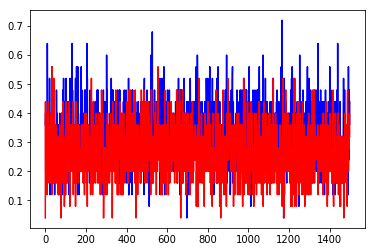

In [46]:
plt.plot(accuracy_train_list, 'blue')
plt.plot(accuracy_test_list, 'red')
plt.show()

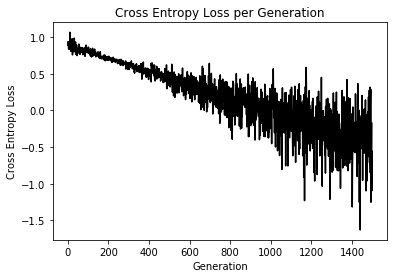

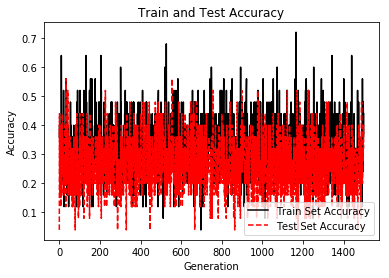

In [47]:
plt.plot(loss_train, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()
plt.plot(accuracy_train_list, 'k-', label='Train Set Accuracy')
plt.plot(accuracy_test_list, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
          
          
          

In [15]:
training_y


array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.])

In [13]:

y_data

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [52]:
texto_final

['ID\tLOW\tAGE\tLWT\tRACE\tSMOKE\tPTL\tHT\tUI\tFTV\tBWT',
 '85\t0\t19\t182\t2\t0\t0\t0\t1\t0\t2523',
 '86\t0\t33\t155\t3\t0\t0\t0\t0\t3\t2551',
 '87\t0\t20\t105\t1\t1\t0\t0\t0\t1\t2557',
 '88\t0\t21\t108\t1\t1\t0\t0\t1\t2\t2594',
 '89\t0\t18\t107\t1\t1\t0\t0\t1\t0\t2600',
 '91\t0\t21\t124\t3\t0\t0\t0\t0\t0\t2622',
 '92\t0\t22\t118\t1\t0\t0\t0\t0\t1\t2637',
 '93\t0\t17\t103\t3\t0\t0\t0\t0\t1\t2637',
 '94\t0\t29\t123\t1\t1\t0\t0\t0\t1\t2663',
 '95\t0\t26\t113\t1\t1\t0\t0\t0\t0\t2665',
 '96\t0\t19\t95\t3\t0\t0\t0\t0\t0\t2722',
 '97\t0\t19\t150\t3\t0\t0\t0\t0\t1\t2733',
 '98\t0\t22\t95\t3\t0\t0\t1\t0\t0\t2750',
 '99\t0\t30\t107\t3\t0\t1\t0\t1\t2\t2750',
 '100\t0\t18\t100\t1\t1\t0\t0\t0\t0\t2769',
 '101\t0\t18\t100\t1\t1\t0\t0\t0\t0\t2769',
 '102\t0\t15\t98\t2\t0\t0\t0\t0\t0\t2778',
 '103\t0\t25\t118\t1\t1\t0\t0\t0\t3\t2782',
 '104\t0\t20\t120\t3\t0\t0\t0\t1\t0\t2807',
 '105\t0\t28\t120\t1\t1\t0\t0\t0\t1\t2821',
 '106\t0\t32\t121\t3\t0\t0\t0\t0\t2\t2835',
 '107\t0\t31\t100\t1\t0\t0\t0\t1\t3

In [27]:
birth_file = requests.get(birthdata_url)
birth_data = birth_file.text.split('\'r\n') [5:]
#birth_header = [x for x in birth_data[0].split( '') if len(x)>=1]
#birth_data = [[float(x) for x in y.split( ')'' if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
print(len(birth_data))
189
print(len(birth_data[0]))

IndexError: list index out of range

In [18]:
import re

patron= re.compile(r'a[3-5]+')
patron

re.compile(r'a[3-5]+', re.UNICODE)

In [25]:
cadena = 'a3445'
found=patron.search(cadena)  # <_sre.SRE_Match object at 0x02303BF0>
print(found) # None 
patron.search(cadena) # <_sre.SRE_Match object at 0x02303C28>
#
cadena = 'ba3445' # la coincidencia no está al principio! 
#
patron.search(cadena)  #  <_sre.SRE_Match object at 0x02303BF0>
print(patron.match(cadena)) # None 

print(re.findall(r'\w+', 'Words, words, words.'))

<_sre.SRE_Match object; span=(0, 5), match='a3445'>
None
['Words', 'words', 'words']
